In [1]:
import datetime as dt
import math
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd 
import pandas_datareader as pdr
import tensorflow as tf # deep learning 
import yfinance as yf

from datetime import datetime
from sklearn.preprocessing import MinMaxScaler # scale data between 0 and 1 ; sklearn = scikit learn
from tensorflow import keras # nweural network functions
from tensorflow.keras import layers # neural netwwork layers

In [18]:
yf.pdr_override()

stock_df = input ("Enter a stock symbol: ") #asking for stock symbol

Year = int(input("Enter start year: "))  #set start year
start = dt.datetime(Year,1,1)
now = dt.datetime.now()



df = pdr.get_data_yahoo(stock_df, start, now)
df.round(2)

Enter a stock symbol: NIO
Enter start year: 2016
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-09-12,6.00,6.93,5.35,6.60,6.60,66849000
2018-09-13,6.62,12.69,6.52,11.60,11.60,158346500
2018-09-14,12.66,13.80,9.22,9.90,9.90,172473600
2018-09-17,9.61,9.75,8.50,8.50,8.50,56323900
2018-09-18,8.73,9.10,7.67,7.68,7.68,41827600
...,...,...,...,...,...,...
2022-07-13,20.23,21.80,20.23,21.09,21.09,50089200
2022-07-14,21.06,21.45,20.66,21.05,21.05,39870500
2022-07-15,20.84,20.90,19.93,20.72,20.72,41251400


Text(0, 0.5, 'Prices ($)')

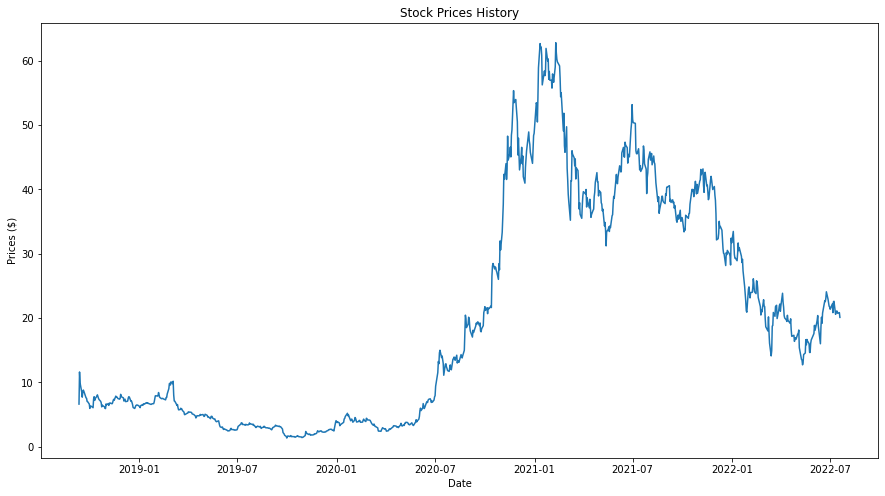

In [19]:
plt.figure(figsize=(15, 8)) 
plt.title('Stock Prices History') # title
plt.plot(df['Close']) 
plt.xlabel('Date') 
plt.ylabel('Prices ($)')

In [20]:
close_prices = df['Close']
values = close_prices.values
training_data_len = math.ceil(len(values)* 0.8) # 80% training data

scaler = MinMaxScaler(feature_range=(0,1)) 
scaled_data = scaler.fit_transform(values.reshape(-1,1))

train_data = scaled_data[0: training_data_len, :]

x_train = [] # features (questions)
y_train = [] # labels (answers)

for i in range(60, len(train_data)): # last 60 days
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
x_train, y_train = np.array(x_train), np.array(y_train) 

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [21]:
test_data = scaled_data[training_data_len-60: , : ] 
x_test = []
y_test = values[training_data_len:]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [22]:
model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(layers.LSTM(100, return_sequences=False))
model.add(layers.Dense(25))
model.add(layers.Dense(1))
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 60, 100)           40800     
_________________________________________________________________
lstm_5 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_4 (Dense)              (None, 25)                2525      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 26        
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________


In [23]:
model.compile(optimizer='adam', loss='mean_squared_error') 
model.fit(x_train, y_train, batch_size= 1, epochs=3) # start training

Epoch 1/3
716/716 [==============================] - 32s 40ms/step - loss: 0.0038
Epoch 2/3
716/716 [==============================] - 29s 41ms/step - loss: 0.0023
Epoch 3/3
716/716 [==============================] - 26s 36ms/step - loss: 0.0013


In [24]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2) 
rmse

1.4214385235247835

/var/folders/pt/fmb666z11znbjc1ys5dz4gpw0000gn/T/ipykernel_3733/3001358295.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


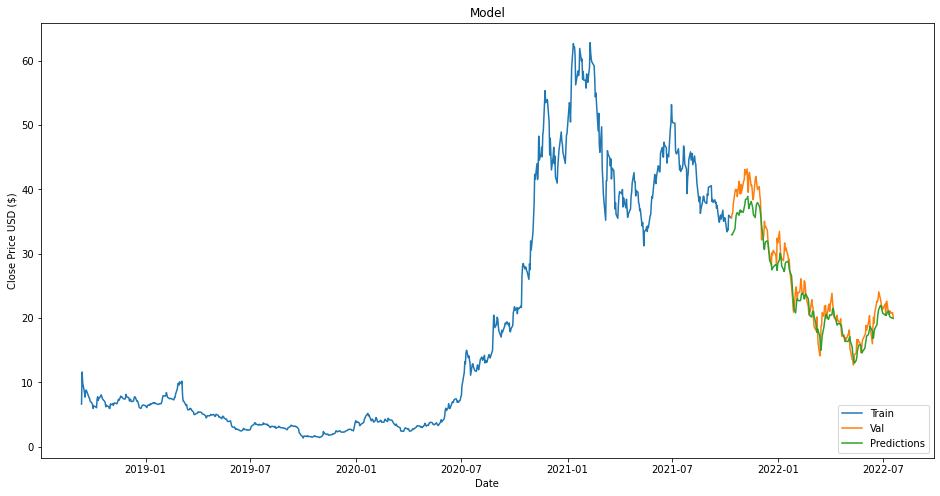

In [25]:
data = df.filter(['Close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()